In [1]:
import os, sys 
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
from torch import nn
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from src import distributions
from src.tools import test_accuracy
from src.mnistm_utils import MNISTM

## Load Data

In [2]:
IMG_SIZE = 32
transform = Compose([
    Resize((IMG_SIZE, IMG_SIZE)), 
    ToTensor(),
    Normalize((0.5), (0.5)),
])
DATASET_PATH = '../datasets/'
DATASET = 'mnist'

model = models.resnet18()
if DATASET == 'kmnist':
    dataset = datasets.KMNIST(DATASET_PATH, train=True, download=True, transform=transform)
    testset = datasets.KMNIST(DATASET_PATH, train=True, download=True, transform=transform)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    NC = 1

elif DATASET == 'mnist':
    dataset = datasets.MNIST(DATASET_PATH,  train=True, download=True, transform=transform)
    testset = datasets.MNIST(DATASET_PATH, train=False, download=True, transform=transform)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    NC = 1
    
elif DATASET == 'usps':
    dataset = datasets.USPS(DATASET_PATH,  train=True, download=True, transform=transform)
    testset = datasets.USPS(DATASET_PATH, train=False, download=True, transform=transform)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    model.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    NC = 1

elif DATASET == 'mnistm':
    dataset = MNISTM(DATASET_PATH,  train=True, download=True, transform=transform)
    testset = MNISTM(DATASET_PATH, train=False, download=True, transform=transform)
    model.fc =  nn.Linear(in_features=512, out_features=10, bias=True)
    NC = 3
    
trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

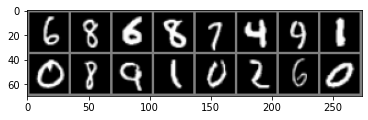

In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
classes = list(range(10))

imshow(torchvision.utils.make_grid(images[:16]))

## Define Classifier

In [4]:
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

## Train

In [5]:
def fit(model, trainloader, testloader, optimizer, loss_fn, epochs=30):
    model.train()
    for epoch in range(epochs):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(trainloader):            
            X_batch, Y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            output = model.forward(X_batch)
            loss = loss_fn(output, Y_batch)
            loss.backward()
            optimizer.step()
            predicted = torch.max(output.data, 1)[1] 
            correct += (predicted == Y_batch).sum()
        test_accuracy(model, testloader)
    return model

In [6]:
model = fit(model, trainloader, testloader, optimizer, loss_fn, 10)

Accuracy of the network: 97.71
Accuracy of the network: 98.07
Accuracy of the network: 98.78
Accuracy of the network: 98.93
Accuracy of the network: 98.51
Accuracy of the network: 99.26
Accuracy of the network: 98.97
Accuracy of the network: 98.84
Accuracy of the network: 99.18
Accuracy of the network: 99.21


In [9]:
model.eval()
torch.save(model.cpu().state_dict(), '../saved_models/classifiers/{}.pt'.format(DATASET))